In [1]:
import numpy as np
import pandas as pd
import pyspark as ps
import matplotlib.pyplot as plt
import csv
import seaborn as sns
import unicodedata

from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

In this notebook I look at the different temporal distribution.
First look at emotion over time:

In [2]:
df = pd.read_json('tweets.json', lines=True)

In [3]:
df.head()

,author_gender,author_user_id,geo_point,lang,main,published,sentiment,source_followers,source_following,source_location,source_spam_probability,tags
0,FEMALE,NaN,NaN,fr,en espérant que 2016 soit meilleur que 2015 qu...,2016-01-01T00:30:04Z,NEUTRAL,80,140,Saint-Maurice,0,NaN
1,UNKNOWN,NaN,NaN,en,nice bmw ...he kills ant s!!!,2016-01-01T12:12:33Z,NEUTRAL,79,196,Hinwil,0,NaN
2,MALE,NaN,NaN,de,"@madmenna ich hab nichts dagegen, wenn mir and...",2016-01-01T19:52:15Z,NEUTRAL,479,783,Schenkon,0,NaN
3,UNKNOWN,NaN,NaN,en,happy new jear!!!! i am back from 2 weeks cuba...,2016-01-01T11:58:03Z,NEUTRAL,79,196,Hinwil,0,NaN
4,UNKNOWN,NaN,NaN,fr,@megadriver16 bonne année à toi je prends beau...,2016-01-01T06:17:28Z,NEUTRAL,75,984,Bâle,0,NaN


In [4]:
df['published'] = pd.to_datetime(df['published'])

In [5]:
def get_time_distribution(times):
    publishing_time = times.map(lambda x: x.hour).value_counts() / times.count()
    publishing_time.sort_index(inplace=True)
    return publishing_time

In [6]:
neg = get_time_distribution(df[df.sentiment == 'NEGATIVE']['published'])
neut = get_time_distribution(df[df.sentiment == 'NEUTRAL']['published'])
pos = get_time_distribution(df[df.sentiment == 'POSITIVE']['published'])

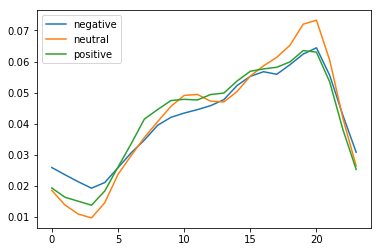

In [7]:
plt.plot(neg)
plt.plot(neut)
plt.plot(pos)
plt.legend(['negative', 'neutral', 'positive'])
plt.show()

In [ ]:
def get_yearly(times):
    publishing_time = times.map(lambda x: x.month).value_counts() / times.count()
#     publishing_time.sort_index(inplace=True)
    return publishing_time

In [ ]:
total_y = get_yearly(df.published)
neg_y = get_yearly(df[df.sentiment == 'NEGATIVE']['published'])
neut_y = get_yearly(df[df.sentiment == 'NEUTRAL']['published'])
pos_y = get_yearly(df[df.sentiment == 'POSITIVE']['published'])

In [ ]:
#the way spinner collected the tweets indicated that there is a difference in the frequency od tweets
sns.tsplot(data=neg_y, color='Purples')
sns.tsplot(data=pos_y, color='Reds')
sns.tsplot(data=neut_y)
plt.legend(['negative', 'positive', 'neutral'])
plt.show()

How the f are we supposed to deal with such an unequally distribued dataset????

In [ ]:
df.author_user_id.isnull().value_counts()

In [ ]:
df.geo_point.isnull().value_counts()

In [ ]:
df.source_location.isnull().value_counts()

In [ ]:
import folium
from folium.plugins import MarkerCluster

In [ ]:
def process_location_data(df):
    """preprocessed data in format as found on cluster:
    df: dataframe, locations should be in 'geo_point'
    """
    non_null = df[~df.geo_point.isnull()]
    virgule = non_null[non_null.geo_point.str.contains(',')].geo_point.str.split(pat=',', expand=True).applymap(float)
    no_virgule = non_null[~non_null.geo_point.str.contains(',')].geo_point.str.split(expand=True).applymap(float)
    return pd.concat([virgule, no_virgule])
    


def build_map(location):
    """build swiss location map
    location: dataframe, locations must of type [lat, long]'
    note: location should not contain more than 5000 locations, otherwise buggy
    """
    SWISS_COORD = [46.85, 8.23] #location of switzerland
    swiss_map = folium.Map(location = SWISS_COORD, zoom_start = 8, tiles = 'cartodbpositron')
    marker_cluster = MarkerCluster().add_to(swiss_map)
    for each in location.iterrows():
        folium.Marker([each[1][0],each[1][1]], ).add_to(marker_cluster)
    return swiss_map

In [ ]:
locations = process_location_data(df)

In [ ]:
swiss_map = build_map(location=locations.head())

In [ ]:
swiss_map